# XOR Swirl

NOTE: both [xor_swirl.ipynb](xor_swirl.ipynb) and [xor_swirl_cascaded.ipynb](xor_swirl_cascaded.ipynb) need to be run before you can run this notebook.

## Imports

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# mpl style context manager
custom_style = lambda : plt.style.context(os.path.abspath('custom.mplstyle'))

## Parameters
(Same as in the data-generating notebooks)

In [2]:
# simulation parameters
dt = 1e-12 # simulation timestep
bitrate = 50e9 # bps
samplerate = 1/dt # new sampling rate
power = 1e-3 #[W]
S = int(samplerate/bitrate+0.5) # timesteps per bit (sampling points per bit)

# training parameters
num_train_bits = 1000
num_test_bits = 10000
learning_rate=0.1
train_bits_seed = 23
test_bits_seed = 42
batch_size = 10 # number of parallel simulations to run during training
latencies = np.array([2.1]) # how many bits delay
latency = 2.1

# source and detector locations:
height = 6
width = 6
sources_at = [1, 8, 15, 22, 29, 35]
detectors_at = slice(None) # all nodes are output nodes
trainable_nodes = []#[6, 11, 17, 22, 28, 33]

# default computation device (cuda or cpu)
device = 'cuda'

# set general seed
torch.manual_seed(7)
np.random.seed(0)


In [3]:
def tplot(dt, field, **kwargs):
    ''' useful visualization function '''
    if torch.is_tensor(field):
        field = field.data.detach().cpu().numpy()
        if field.shape[0]==2:
            field = field[0] + 1j*field[1]
    t = 1e12*np.arange(field.shape[0])*dt + kwargs.pop('start', 0)
    plt.xlabel('Time [ps]')
    return plt.plot(t, np.real(field), **kwargs)

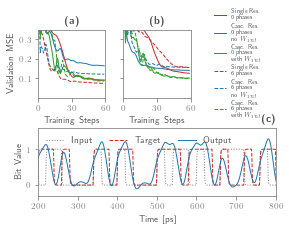

In [4]:
with custom_style():
    plt.figure(figsize=(4,3.3))
    legend_size=6
    
    
    # fig (a)
    plt.subplot(231)
    plt.title(r'\textbf{(a)}')
    plt.ylim(0, 0.35)
    plt.yticks([0.1,0.2,0.3])
    plt.ylabel('Validation MSE')
    plt.xlabel('Training Steps')
    plt.xlim(0,60)
    plt.xticks([0,30,60])
    ax = plt.gca()
    
    # A. Normal Reservoir - no phases optimized
    losses = np.load('reservoir_losses/res0_xor.npy')
    plt.plot(losses, ls='-', color='C0', label='Single Res.\n 0 phases')
    
    # C. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres0_xor_no_w_int.npy')
    plt.plot(losses, ls='-', color='C1', label='Casc. Res.\n 0 phases\n no $W_{int}$')
    
    # E. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres0_xor.npy')
    plt.plot(losses, ls='-', color='C2', label='Casc. Res.\n 0 phases\n with $W_{int}$')
    
    # B. Normal Reservoir - 2 phases optimized
    losses = np.load('reservoir_losses/res6_xor.npy')
    plt.plot(losses, ls='--', color='C0', label='Single Res.\n 6 phases')
    
    # D. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres6_xor_no_w_int.npy')
    plt.plot(losses, ls='--', color='C1', label='Casc. Res.\n 6 phases\n no $W_{int}$')
    
    # F. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres6_xor.npy')
    plt.plot(losses, ls='--', color='C2', label='Casc. Res.\n 6 phases\n with $W_{int}$')

    # Fig (b)
    plt.subplot(232)
    plt.title(r'\textbf{(b)}')
    plt.ylim(0, 0.35)
    plt.yticks([0.1,0.2,0.3],["","",""])
    plt.xlim(0,60)
    plt.xticks([0,30,60])
    plt.xlabel('Training Steps')
    
    # A. Normal reservoir - no phses optimized
    losses = np.load('reservoir_losses/res0_xor2.npy')
    plt.plot(losses, ls='-', color='C0', label=r'Single Res. | 0 phases')
    
    # C. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres0_xor2_no_w_int.npy')
    plt.plot(losses, ls='-', color='C1', label='Casc. Res. | 0 phases | no $W_{int}$')
    
    # E. Cascaded Reservoir - 0 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres0_xor2.npy')
    plt.plot(losses, ls='-', color='C2', label='Casc. Res. | 0 phases | with $W_{int}$')
   
    # B. Normal reservoir - 6 phases optimized
    losses = np.load('reservoir_losses/res6_xor2.npy')
    plt.plot(losses, ls='--', color='C0', label=r'Single Res. | 6 phases')
    
    # D. Cascaded Reservoir - 6 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres6_xor2_no_w_int.npy')
    plt.plot(losses, ls='--', color='C1', label='Casc. Res. | 6 phases | no $W_{int}$')
    
    # F. Cascaded Reservoir - 6 phases optimized - no intermediate weights
    losses = np.load('reservoir_losses/cascres6_xor2.npy')
    plt.plot(losses, ls='--', color='C2', label='Casc. Res. | 6 phases | with $W_{int}$')
    
    plt.tight_layout()
    
    # legend
    plt.subplot(233)
    plt.axis('off')
    plt.legend(*ax.get_legend_handles_labels(), ncol=1, loc='center left', framealpha=0, prop={'size':legend_size})
    

    # fig(c)
    plt.subplot2grid((2,3), (1,0), colspan=3)
    plt.title(r'\textbf{(c)}', loc='right')
    plt.yticks([0, 1])
    plt.ylim(-.3, 1.6)
    
    test_stream = np.load('reservoir_losses/test_stream_xor.npy')
    test_target = np.load('reservoir_losses/test_target_xor.npy')
    detected = np.load('reservoir_losses/detected_xor.npy')
    linestyles = ['-','--','dotted','dashdot']
    loss_types = ['0','2']
    latency = 2.1
    tplot(dt, test_stream, label='Input', color='grey', ls='dotted')
    tplot(dt, test_target, label='Target', ls='--')
    plt.ylabel('Bit Value')
    plt.xlim(200,800)
    tplot(dt, detected, start=-latency*samplerate/bitrate*dt*1e12, label='Output')
    plt.legend(ncol=3, framealpha=0.0, loc='upper left')
    plt.subplots_adjust(bottom=0.2)
    
    #plt.tight_layout()
    plt.show()